# Drive Linking


In [1]:
from google.colab import drive                                                  # Importa il modulo Drive di Google Colab

drive.mount('/content/drive')                                                   # Indirizzo base del drive

Mounted at /content/drive


# Library

In [ ]:
!pip install nltk
!pip install googletrans==4.0.0-rc1
!pip install langdetect
!pip install d2l

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from googletrans import Translator
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from sklearn.model_selection import train_test_split
import os
import multiprocessing
import d2l
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import time
import scipy.io as sio                                      # For working with MATLAB files, especially for reading and writing .mat files
import torch.nn as nn                                       # For building neural networks

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Check Device

In [ ]:
# Imposta il dispositivo per l'esecuzione del modello su GPU se disponibile, altrimenti usa la CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Version: " + str(torch.__version__))
print("Avaible?: " + str(torch.cuda.is_available()))
print("Device: " + str(torch.cuda.get_device_name(0)))
print("Run GPU?: " + str(device))

Version: 2.3.0+cu121
Avaible?: True
Device: Tesla T4
Run GPU?: cuda:0


# Path

In [ ]:
DATA_PATH = '/content/drive/MyDrive/CCS/Dataset'
DATASET_PATH = DATA_PATH + '/enron_spam_data.csv'
DATASET_CLEAR_PATH = DATA_PATH + '/enron_spam_data_clear.csv'
TRAIN_PATH = DATA_PATH + '/train.csv'
VAL_PATH = DATA_PATH + '/val.csv'
TEST_PATH = DATA_PATH + '/test.csv'
WEIGHTS_PATH = DATA_PATH + '/Weights'
TRAIN_FINAL_PATH = DATA_PATH + 'train_final.csv'
BEST_WEIGHT_PATH = WEIGHTS_PATH + '/Best_Weight'

# Data Visualization & Pre-Processing

In [ ]:
# Leggi il file CSV e assicurati che contenga colonne 'text' e 'label'
df = pd.read_csv(DATASET_PATH)

# Riconfigura la colonna 'Spam/Ham' in 1 per 'spam' e 0 per 'ham'
df['Spam/Ham'] = df['Spam/Ham'].map({'spam': 1, 'ham': 0})

# Unisci le colonne 'Subject' e 'Message' in una nuova colonna chiamata 'Text'
df['Text'] = df['Subject'] + ' ' + df['Message']

# Rimuovi le colonne specificate
df = df.drop(columns=['Date', 'Subject', 'Message'])

# Ordina le colonne: 'Message ID', 'Text', 'Spam/Ham'
df = df[['Message ID', 'Text', 'Spam/Ham']]

In [ ]:
# Individua i valori mancanti per ciascuna riga
missing_values = df.isnull()

# Conta i valori mancanti per ogni etichetta
missing_per_label = {}
total_per_label = df['Spam/Ham'].value_counts()
for label in df['Spam/Ham'].unique():
    missing_in_label = missing_values[df['Spam/Ham'] == label]
    missing_per_label[label] = missing_in_label.sum()

# Calcola la percentuale dei valori mancanti per ogni etichetta
percent_missing_per_label = {label: (counts / total_per_label[label] * 100) for label, counts in missing_per_label.items()}

# Stampa le informazioni sui valori mancanti per ogni etichetta
print("Valori mancanti per etichetta e percentuale:")
for label, counts in missing_per_label.items():
    print(f"\nLabel {label}:")
    perc = percent_missing_per_label[label]
    print(counts)
    print(f"\nPercentuale dei valori mancanti per label {label}:")
    print(percent_missing_per_label[label])

# Stampa il numero totale di messaggi per ciascuna etichetta
print("\nNumero totale di messaggi per ciascuna etichetta:")
for label, total in total_per_label.items():
    print(f"Label {label}: {total} messaggi")

# Controlla se in quelli in cui manca il subject manca anche il body
missing_subject_and_body = df[missing_values['Text']]

# Conta quanti messaggi sono label 0 e quanti 1
missing_subject_and_body_per_label = missing_subject_and_body['Spam/Ham'].value_counts()

Valori mancanti per etichetta e percentuale:

Label 0:
Message ID     0
Text          52
Spam/Ham       0
dtype: int64

Percentuale dei valori mancanti per label 0:
Message ID    0.000000
Text          0.314294
Spam/Ham      0.000000
dtype: float64

Label 1:
Message ID      0
Text          557
Spam/Ham        0
dtype: int64

Percentuale dei valori mancanti per label 1:
Message ID    0.000000
Text          3.243841
Spam/Ham      0.000000
dtype: float64

Numero totale di messaggi per ciascuna etichetta:
Label 1: 17171 messaggi
Label 0: 16545 messaggi


In [ ]:
# Elimina le righe contenenti missing value
df.dropna(subset=['Text'], inplace=True)

In [ ]:
# Funzione di traduzione in inglese
def translate_to_english(text):
    # Verifica se il testo è già in inglese
    try:
        detected_lang = detect(text)
        if detected_lang == 'en':
            return text
    except LangDetectException as e:
        print(f"Error detecting language: {e}")
        return text  # Se non riesce a rilevare la lingua, considera il testo come già in inglese

    translator = Translator()
    chunk_size = 500  # Definisci la dimensione del chunk
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]  # Dividi il testo in chunk
    translated_chunks = []

    try:
        for chunk in chunks:
            translated_chunk = translator.translate(chunk, src='auto', dest='en').text
            translated_chunks.append(translated_chunk)
        translated_text = ' '.join(translated_chunks)  # Concatenazione dei chunk tradotti
        return translated_text
    except Exception as e:
        print(f"Translation failed for text: {text}. Error: {e}")
        return text  # Se la traduzione fallisce, restituisci il testo originale

# Funzione di lemmatizzazione con nltk
def get_wordnet_pos(word):
    """Mappa i tag di POS a WordNet POS."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

# Funzione di pre-elaborazione del testo
def preprocess_text(text):
    translated_text = translate_to_english(text)
    clean_text = re.sub(r'[^\w\s]', '', translated_text)
    clean_text = re.sub(r'\b(in|the|all|for|and|on)\b', '_connector_', clean_text)

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    tokens = tokenizer.tokenize(clean_text)

    stop_words = set(stopwords.words('english'))

    # Rimozione delle stop words senza tqdm
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatizzazione
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Applica le trasformazioni alla colonna 'Text'
df['Text'] = df['Text'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Error detecting language: No features in text.
Error detecting language: No features in text.
Translation failed for text: * * * * * spam * * * * * ðï  à ¡ ±. Error: the JSON object must be str, bytes or bytearray, not NoneType
Translation failed for text: bank - erbschaft aus sicherheit grund muessen sie ihr antwort zu diesem email
an : donaldabeki @ weedmail . com
geschickt werden .
sehr geehrter herren !
ich bin ein hoehere bank angestellte und in der abteilung
firmekundebetreung der bank for international settlements ( bis )
[ sud afrika www . bis . org ] , dieser abteilung ist auch zustaendig fuer den
enfuehr / ausfuehr des unsere landes bearbeiter guetern . vor kuerze
wird einer menge geld vom unsere buchfuerhrer enteckt worden in
einer konto welchen in einer offshore eingerichtet und deponiert
worden .
dieser summe ist funfzehn komma drei millioned united states dollars .
dieser betrag gehoert einer unsere auslandskunden , der
zussammen mit seiner gesamte familie am september 1

In [ ]:
df

,Message ID,Text,Spam/Ham
1,1,vast ##ar resource inc gary production _ conne...,0
2,2,cal ##pine daily gas nomination cal ##pine dai...,0
3,3,issue f ##yi see note already do stella forwar...,0
4,4,meter 72 ##6 ##8 nov allocation f ##yi forward...,0
5,5,mc ##mu ##llen gas _ connector _ 11 99 jackie ...,0
...,...,...,...
33711,33711,iso 88 ##59 1 q good _ news _ c ed ##alis ##s ...,1
33712,33712,_ connector _ pre ##script medicine _ connecto...,1
33713,33713,_ connector _ next generation online pharmacy ...,1
33714,33714,b ##lo ##ow _ connector _ 5 10 time _ connecto...,1


In [ ]:
# Salva il DataFrame modificato in un nuovo file CSV
df.to_csv(DATASET_CLEAR_PATH, index=False)

# Split

Ora hai i tuoi dati divisi in modo stratificato in set di addestramento (65%), validazione (15%) e test (20%)

In [ ]:
# Carica il tuo csv in un DataFrame pandas
df = pd.read_csv(DATASET_CLEAR_PATH)

In [ ]:
# Supponiamo che 'colonna_target' sia la tua variabile target
X = df.drop('Spam/Ham', axis=1)
y = df['Spam/Ham']

# Dividi i dati in set di addestramento e altri dati (validazione + test)
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# Dividi ulteriormente X_other e y_other in set di validazione e test
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=(0.2/0.35), stratify=y_other, random_state=42)

In [ ]:
# Salva il set di addestramento in un file CSV
train = pd.concat([X_train, y_train], axis=1)
train.to_csv(TRAIN_PATH, index=False)

# Salva il set di validazione in un file CSV
val = pd.concat([X_val, y_val], axis=1)
val.to_csv(VAL_PATH, index=False)

# Salva il set di test in un file CSV
test = pd.concat([X_test, y_test], axis=1)
test.to_csv(TEST_PATH, index=False)

In [ ]:
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)
test_data = pd.read_csv(TEST_PATH)

In [ ]:
train_data

,Message ID,Text,Spam/Ham
0,3846,ad _ connector _ felt stiff ##en _ connector _...,1
1,21416,wait _ connector _ name early ##lar ##ena age ...,1
2,21205,waste money buying e usa 8 op 03 ##5 4 wo 5 ##...,1
3,22261,software 3000 shatter hello get thousand softw...,1
4,110,vale ##ro meter treat sep ##erate ##ly ticket ...,0
...,...,...,...
21514,13634,mark palmer ask forward per mark palmer instru...,0
21515,25026,_ connector _ _ connector _ top page google gu...,1
21516,15384,_ connector _ best sa 7 _ 0 ##d erin ##g ##l #...,1
21517,5240,color cop ##ier hello l ##yn certainly hope en...,0


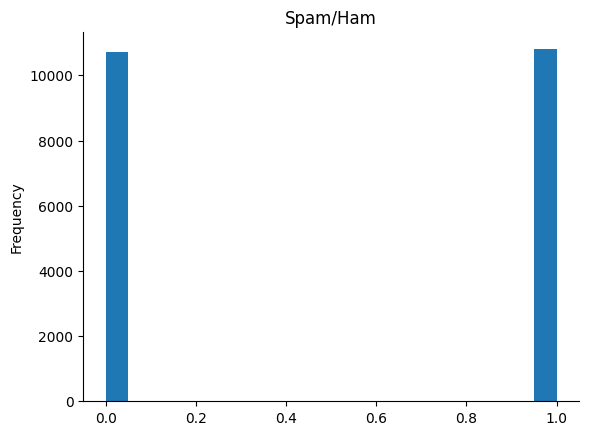

In [ ]:
from matplotlib import pyplot as plt
train_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
val_data

,Message ID,Text,Spam/Ham
0,6580,new power ##mo ##d 97 xl ##s marty absolutely ...,0
1,17736,start date 1 15 02 hour ##ah ##ead hour 2 star...,0
2,26750,spa ##m mail warn notification attachment remo...,1
3,9783,computer file protection dear hulk ##j ##r wan...,1
4,8385,confirmation order automatic confirmation _ co...,0
...,...,...,...
4961,1446,hp ##l expense contract f ##yi call question t...,0
4962,32438,urgent please dr dan nk ##anga zenith internat...,1
4963,30791,cheap online tablet shu ##nt willow ##y ti ##t...,1
4964,6479,interview schedule _ connector _ greg mi ##kk ...,0


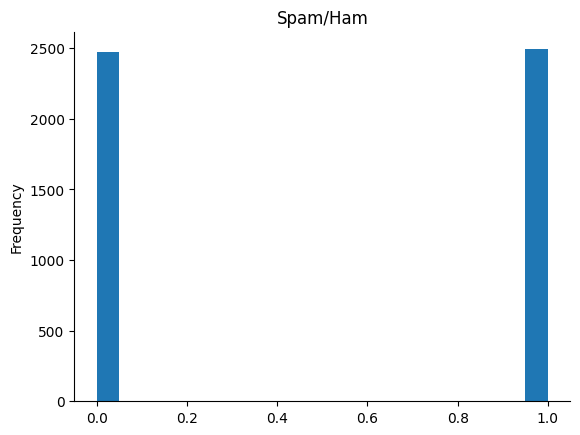

In [ ]:
from matplotlib import pyplot as plt
val_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
test_data

,Message ID,Text,Spam/Ham
0,24428,rag hard erection formula herbal alternative _...,1
1,23097,brent note sally rough draft note visit yester...,0
2,22930,commodity logic leslie reef work _ connector _...,0
3,17720,start date 1 14 02 hour ##ah ##ead hour 13 sta...,0
4,4953,cheap pharmacy rc would like cheap overseas dr...,1
...,...,...,...
6617,642,98 63 ##7 ##3 go 98 63 ##7 ##3 sit ##ara deal ...,0
6618,30229,inn ##ume ##rable 88 vic ##od ##in professor g...,1
6619,18548,ad ##b proposal zu ##ma chris 20 ##a crescent ...,1
6620,14511,f ##w status plan revision hi louise attach sc...,0


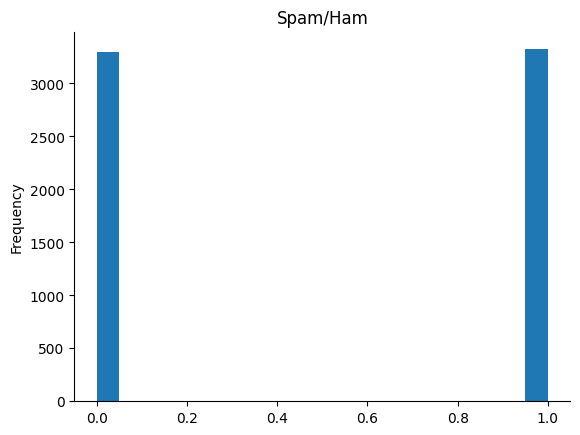

In [ ]:
from matplotlib import pyplot as plt
test_data['Spam/Ham'].plot(kind='hist', bins=20, title='Spam/Ham')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Model Definition

In [ ]:
model_name = 'distilbert-base-uncased'
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
def get_vocab_from_model(model_name):
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    return tokenizer.get_vocab()

vocab = get_vocab_from_model(model_name)

# DataLoader Train e Validation

In [ ]:
class DistilBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_len, model_name):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)

        dataframe['Text'] = dataframe['Text'].fillna('').astype(str)

        sentences = dataframe['Text']
        labels = dataframe['Spam/Ham']

        all_tokens = [self.tokenizer.tokenize(s) for s in sentences]

        self.labels = torch.tensor(labels.values, dtype=torch.long)
        self.max_len = max_len
        self.all_token_ids, self.valid_lens = self._preprocess(all_tokens)
        print('Read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_tokens)
        all_token_ids = [token_ids for token_ids, valid_len in out]
        valid_lens = [valid_len for token_ids, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(valid_lens, dtype=torch.long))

    def _mp_worker(self, tokens):
        self._truncate_tokens(tokens)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        token_ids += [self.tokenizer.pad_token_id] * (self.max_len - len(token_ids))
        valid_len = len(tokens)
        return token_ids, valid_len

    def _truncate_tokens(self, tokens):
        while len(tokens) > self.max_len - 2:
            tokens.pop()

    def __getitem__(self, idx):
        input_tensor = self.all_token_ids[idx]
        valid_len_tensor = self.valid_lens[idx]
        label_tensor = self.labels[idx]
        return (input_tensor, valid_len_tensor), label_tensor

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)

In [ ]:
batch_size = 512
max_len = 128

train_set = DistilBERTDataset(train_data, max_len, model_name)
val_set = DistilBERTDataset(val_data, max_len, model_name)

Read 21519 examples
Read 4966 examples
Read 4966 examples


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True,num_workers=2)

# Training con Validation

In [ ]:
# Define the train_loop_validation function
def train_loop_validation(train_dataloader, val_dataloader, startEpoch, numEpochs, model_conv, criterion, optimizer, best_acc, best_loss, best_epoca, outputPath, scheduler=None):

    train_files = ['lossTrain.txt', 'AccTrain.txt', 'lossVal.txt', 'AccVal.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Training loop
        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            (inputs, valid_lens), labels = batch

            inputs = inputs.to(device)
            valid_lens = valid_lens.to(device)
            labels = labels.view(-1, 1).float().to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model_conv(inputs)
            logits = outputs.logits  # Accedi ai logits dall'oggetto SequenceClassifierOutput
            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            modelLoss_train += loss.item() * inputs.size(0)
            modelAcc_train += ((logits > 0.5) == labels).sum().item()
            totalSize += inputs.size(0)

        epoch_loss = modelLoss_train / totalSize
        epoch_acc = modelAcc_train / totalSize

        # Validation loop
        model_conv.eval()
        modelLoss_val = 0.0
        modelAcc_val = 0.0
        totalSize_val = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, total=len(val_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Validation"):
                (inputs, valid_lens), labels = batch

                inputs = inputs.to(device)
                valid_lens = valid_lens.to(device)
                labels = labels.view(-1, 1).float().to(device)

                outputs = model_conv(inputs)
                logits = outputs.logits  # Accedi ai logits dall'oggetto SequenceClassifierOutput
                loss = criterion(logits, labels)

                modelLoss_val += loss.item() * inputs.size(0)
                modelAcc_val += ((logits > 0.5) == labels).sum().item()
                totalSize_val += inputs.size(0)

        val_loss = modelLoss_val / totalSize_val
        val_acc = modelAcc_val / totalSize_val

        time_elapsed = time.time() - since
        current_lr = optimizer.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, epoch_loss, epoch_acc, totalSize_val, val_loss, val_acc, time_elapsed // 60, time_elapsed % 60, current_lr))

        if val_acc > best_acc or (val_acc == best_acc and val_loss < best_loss):
            best_acc = val_acc
            best_loss = val_loss
            best_epoca = epoch
            print('     .... Saving best weights ....')
            torch.save(model_conv.state_dict(), os.path.join(outputPath, 'best_model_weights.pth'))

        with open(os.path.join(outputPath, 'lossTrain.txt'), 'a') as f:
            f.write(f'{epoch_loss}\n')
        with open(os.path.join(outputPath, 'AccTrain.txt'), 'a') as f:
            f.write(f'{epoch_acc}\n')
        with open(os.path.join(outputPath, 'lossVal.txt'), 'a') as f:
            f.write(f'{val_loss}\n')
        with open(os.path.join(outputPath, 'AccVal.txt'), 'a') as f:
            f.write(f'{val_acc}\n')

        if scheduler:
            scheduler.step(val_loss)

    return best_epoca

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

criterion = nn.BCEWithLogitsLoss().to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Updated hyperparameters
learning_rate = 0.001                                                           # Learning rate for the optimizer
num_epochs = 40                                                                 # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)
best_epoch = -1                                                                 # Epoch corresponding to the best saved model

# Replace the last layer for binary classification
num_ftrs = model.classifier.out_features                                        # Number of output features from the penultimate layer
# Replace the classifier layer
model.classifier = nn.Linear(model.classifier.in_features, 1).to(device)

# Freeze all layers except the classifier layer
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

# Define criterion and optimizer

optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Call the training function with validation
best_epoch = train_loop_validation(train_dataloader, val_dataloader, startEpoch, num_epochs, model, criterion, optimizer, best_acc, best_loss, best_epoch, WEIGHTS_PATH)

Epoch 1/40 - Validation: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Epoch 1][TRAIN on 21519 [Loss: 0.5187  ACC: 0.7039]][VAL on 4966 [Loss: 0.5283  ACC: 0.6953]][TIME: 1 m 24 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 2/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 2][TRAIN on 21519 [Loss: 0.3816  ACC: 0.8050]][VAL on 4966 [Loss: 0.3342  ACC: 0.8496]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 3/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 3][TRAIN on 21519 [Loss: 0.3385  ACC: 0.8307]][VAL on 4966 [Loss: 0.3591  ACC: 0.8214]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 4/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 4][TRAIN on 21519 [Loss: 0.3195  ACC: 0.8460]][VAL on 4966 [Loss: 0.3564  ACC: 0.8085]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 5/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 5][TRAIN on 21519 [Loss: 0.3245  ACC: 0.8424]][VAL on 4966 [Loss: 0.3380  ACC: 0.8343]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 6/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 6][TRAIN on 21519 [Loss: 0.2988  ACC: 0.8574]][VAL on 4966 [Loss: 0.2847  ACC: 0.8953]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 7/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 7][TRAIN on 21519 [Loss: 0.2906  ACC: 0.8618]][VAL on 4966 [Loss: 0.3643  ACC: 0.8149]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 8/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 8][TRAIN on 21519 [Loss: 0.2937  ACC: 0.8626]][VAL on 4966 [Loss: 0.2837  ACC: 0.8894]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 9/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 9][TRAIN on 21519 [Loss: 0.2833  ACC: 0.8680]][VAL on 4966 [Loss: 0.2561  ACC: 0.9007]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 10/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 10][TRAIN on 21519 [Loss: 0.2793  ACC: 0.8667]][VAL on 4966 [Loss: 0.2761  ACC: 0.8818]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 11/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 11][TRAIN on 21519 [Loss: 0.2787  ACC: 0.8716]][VAL on 4966 [Loss: 0.2493  ACC: 0.9031]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 12/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 12][TRAIN on 21519 [Loss: 0.2675  ACC: 0.8774]][VAL on 4966 [Loss: 0.2488  ACC: 0.8790]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 13/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 13][TRAIN on 21519 [Loss: 0.2675  ACC: 0.8781]][VAL on 4966 [Loss: 0.2673  ACC: 0.8913]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 14/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 14][TRAIN on 21519 [Loss: 0.2688  ACC: 0.8756]][VAL on 4966 [Loss: 0.2436  ACC: 0.8993]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 15/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 15][TRAIN on 21519 [Loss: 0.2633  ACC: 0.8768]][VAL on 4966 [Loss: 0.2630  ACC: 0.8947]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 16/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 16][TRAIN on 21519 [Loss: 0.2602  ACC: 0.8814]][VAL on 4966 [Loss: 0.2300  ACC: 0.9031]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 17/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Epoch 17][TRAIN on 21519 [Loss: 0.2553  ACC: 0.8810]][VAL on 4966 [Loss: 0.2481  ACC: 0.8882]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 18/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 18][TRAIN on 21519 [Loss: 0.2703  ACC: 0.8721]][VAL on 4966 [Loss: 0.2288  ACC: 0.8768]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 19/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 19][TRAIN on 21519 [Loss: 0.2591  ACC: 0.8793]][VAL on 4966 [Loss: 0.2472  ACC: 0.8860]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 20/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 20][TRAIN on 21519 [Loss: 0.2523  ACC: 0.8824]][VAL on 4966 [Loss: 0.2251  ACC: 0.9176]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 21/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 21][TRAIN on 21519 [Loss: 0.2433  ACC: 0.8902]][VAL on 4966 [Loss: 0.2243  ACC: 0.8955]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 22/40 - Validation: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Epoch 22][TRAIN on 21519 [Loss: 0.2501  ACC: 0.8862]][VAL on 4966 [Loss: 0.2310  ACC: 0.9092]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 23/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Epoch 23][TRAIN on 21519 [Loss: 0.2483  ACC: 0.8871]][VAL on 4966 [Loss: 0.2452  ACC: 0.9080]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 24/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 24][TRAIN on 21519 [Loss: 0.2434  ACC: 0.8883]][VAL on 4966 [Loss: 0.2400  ACC: 0.9076]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 25/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 25][TRAIN on 21519 [Loss: 0.2448  ACC: 0.8889]][VAL on 4966 [Loss: 0.2175  ACC: 0.8905]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 26/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 26][TRAIN on 21519 [Loss: 0.2359  ACC: 0.8919]][VAL on 4966 [Loss: 0.2175  ACC: 0.9209]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 27/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 27][TRAIN on 21519 [Loss: 0.2424  ACC: 0.8896]][VAL on 4966 [Loss: 0.2118  ACC: 0.9025]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 28/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 28][TRAIN on 21519 [Loss: 0.2360  ACC: 0.8926]][VAL on 4966 [Loss: 0.2415  ACC: 0.9031]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 29/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 29][TRAIN on 21519 [Loss: 0.2373  ACC: 0.8913]][VAL on 4966 [Loss: 0.2085  ACC: 0.9132]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 30/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 30][TRAIN on 21519 [Loss: 0.2349  ACC: 0.8925]][VAL on 4966 [Loss: 0.2128  ACC: 0.9186]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 31/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 31][TRAIN on 21519 [Loss: 0.2333  ACC: 0.8935]][VAL on 4966 [Loss: 0.2288  ACC: 0.9090]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 32/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 32][TRAIN on 21519 [Loss: 0.2291  ACC: 0.8947]][VAL on 4966 [Loss: 0.2174  ACC: 0.9195]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 33/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 33][TRAIN on 21519 [Loss: 0.2273  ACC: 0.8971]][VAL on 4966 [Loss: 0.2005  ACC: 0.9203]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 34/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 34][TRAIN on 21519 [Loss: 0.2285  ACC: 0.8963]][VAL on 4966 [Loss: 0.1967  ACC: 0.9142]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 35/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 35][TRAIN on 21519 [Loss: 0.2384  ACC: 0.8905]][VAL on 4966 [Loss: 0.2421  ACC: 0.8494]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 36/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 36][TRAIN on 21519 [Loss: 0.2305  ACC: 0.8935]][VAL on 4966 [Loss: 0.2025  ACC: 0.9170]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 37/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Epoch 37][TRAIN on 21519 [Loss: 0.2274  ACC: 0.8943]][VAL on 4966 [Loss: 0.2082  ACC: 0.8911]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 38/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 38][TRAIN on 21519 [Loss: 0.2342  ACC: 0.8934]][VAL on 4966 [Loss: 0.2263  ACC: 0.9213]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


Epoch 39/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Epoch 39][TRAIN on 21519 [Loss: 0.2358  ACC: 0.8927]][VAL on 4966 [Loss: 0.2030  ACC: 0.8979]][TIME: 1 m 27 s] [LR: 0.00100]


Epoch 40/40 - Validation: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Epoch 40][TRAIN on 21519 [Loss: 0.2312  ACC: 0.8951]][VAL on 4966 [Loss: 0.2038  ACC: 0.9215]][TIME: 1 m 27 s] [LR: 0.00100]
     .... Saving best weights ....


# Metrics Plot

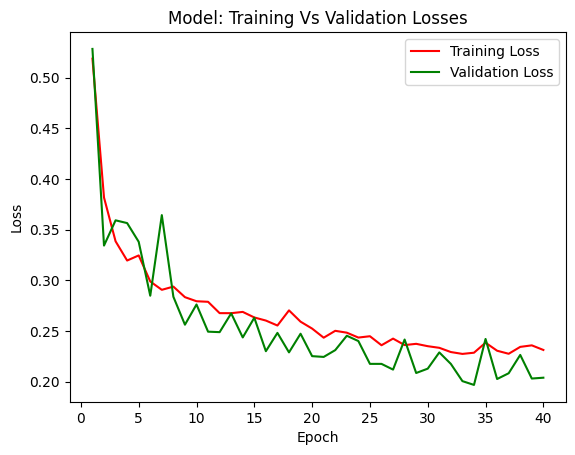

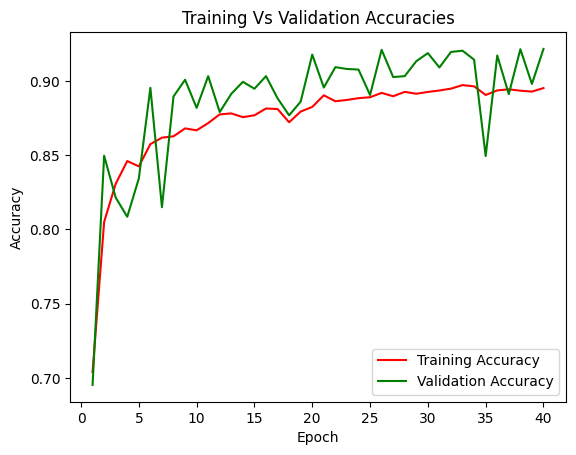

In [ ]:
# Initialization of lists for losses and accuracies
loss_model_train = []
loss_model_val = []
acc_model_train = []
acc_model_val = []

# Reading training loss files
loss_train_path = os.path.join(WEIGHTS_PATH, 'lossTrain.txt')
with open(loss_train_path, 'r') as file:
    loss_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation loss files
loss_val_path = os.path.join(WEIGHTS_PATH, 'lossVal.txt')
with open(loss_val_path, 'r') as file:
    loss_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation losses
plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, len(loss_model_train) + 1), loss_model_train, color='r', label="Training Loss")
plt.plot(range(1, len(loss_model_val) + 1), loss_model_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'LossTrainVal.png'))

# Reading training accuracy files
acc_train_path = os.path.join(WEIGHTS_PATH, 'AccTrain.txt')
with open(acc_train_path, 'r') as file:
    acc_model_train = [float(line.strip()) for line in file.readlines()]

# Reading validation accuracy files
acc_val_path = os.path.join(WEIGHTS_PATH, 'AccVal.txt')
with open(acc_val_path, 'r') as file:
    acc_model_val = [float(line.strip()) for line in file.readlines()]

# Plotting training and validation accuracies
plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, len(acc_model_train) + 1), acc_model_train, color='r', label="Training Accuracy")
plt.plot(range(1, len(acc_model_val) + 1), acc_model_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(os.path.join(WEIGHTS_PATH, 'AccTrainVal.png'))

# Dataloader Dataset

In [ ]:
class DistilBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_len, model_name):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)

        dataframe['Text'] = dataframe['Text'].fillna('').astype(str)

        sentences = dataframe['Text']
        labels = dataframe['Spam/Ham']

        all_tokens = [self.tokenizer.tokenize(s) for s in sentences]

        self.labels = torch.tensor(labels.values, dtype=torch.long)
        self.max_len = max_len
        self.all_token_ids, self.valid_lens = self._preprocess(all_tokens)
        print('Read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_tokens)
        all_token_ids = [token_ids for token_ids, valid_len in out]
        valid_lens = [valid_len for token_ids, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(valid_lens, dtype=torch.long))

    def _mp_worker(self, tokens):
        self._truncate_tokens(tokens)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        token_ids += [self.tokenizer.pad_token_id] * (self.max_len - len(token_ids))
        valid_len = len(tokens)
        return token_ids, valid_len

    def _truncate_tokens(self, tokens):
        while len(tokens) > self.max_len - 2:
            tokens.pop()

    def __getitem__(self, idx):
        input_tensor = self.all_token_ids[idx]
        valid_len_tensor = self.valid_lens[idx]
        label_tensor = self.labels[idx]
        return (input_tensor, valid_len_tensor), label_tensor

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
# Leggi i dati dai file CSV
train_data = pd.read_csv(TRAIN_PATH)
val_data = pd.read_csv(VAL_PATH)

# Unisci i due DataFrame
combined_data = pd.concat([train_data, val_data], ignore_index=True)

# Fai lo shuffle del DataFrame combinato
shuffled_data = combined_data.sample(frac=1).reset_index(drop=True)

# Salva il DataFrame combinato e mescolato al percorso specificato
shuffled_data.to_csv(TRAIN_FINAL_PATH, index=False)

In [ ]:
batch_size = 512
max_len = 128

In [ ]:
final_train_data = pd.read_csv(TRAIN_FINAL_PATH)

final_train_set = DistilBERTDataset(final_train_data, max_len, model_name)
final_train_dataloader = torch.utils.data.DataLoader(final_train_set, batch_size, shuffle=True,num_workers=2)

Read 26485 examples
Read 6622 examples


In [ ]:
test_data = pd.read_csv(TEST_PATH)
test_set = DistilBERTDataset(test_data, max_len, model_name)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True,num_workers=2)

# Training

In [ ]:
def train_loop(train_dataloader, startEpoch, numEpochs, model_conv, criterion, optimizer, outputPath, scheduler=None):

    train_files = ['lossTrain.txt', 'AccTrain.txt']
    for filename in train_files:
        filepath = os.path.join(outputPath, filename)
        if os.path.exists(filepath):
            os.remove(filepath)

    for epoch in range(startEpoch, numEpochs + 1):
        since = time.time()

        modelLoss_train = 0.0
        modelAcc_train = 0.0

        model_conv.train()
        totalSize = 0

        # Training loop
        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch}/{numEpochs} - Training"):
            (inputs, valid_lens), labels = batch

            inputs = inputs.to(device)
            valid_lens = valid_lens.to(device)
            labels = labels.view(-1, 1).float().to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model_conv(inputs)
            logits = outputs.logits  # Access logits from the SequenceClassifierOutput object
            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            modelLoss_train += loss.item() * inputs.size(0)
            modelAcc_train += ((logits > 0.5) == labels).sum().item()
            totalSize += inputs.size(0)

        epoch_loss = modelLoss_train / totalSize
        epoch_acc = modelAcc_train / totalSize

        time_elapsed = time.time() - since
        current_lr = optimizer.param_groups[0]['lr']

        print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s] [LR: %.5f]'
              % (epoch, totalSize, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60, current_lr))

        # Save weights after each epoch, overwriting them
        torch.save(model_conv.state_dict(), os.path.join(outputPath, 'weights.pth'))

        with open(os.path.join(outputPath, 'lossTrain.txt'), 'a') as f:
            f.write(f'{epoch_loss}\n')
        with open(os.path.join(outputPath, 'AccTrain.txt'), 'a') as f:
            f.write(f'{epoch_acc}\n')

        if scheduler:
            scheduler.step(epoch_loss)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

criterion = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Updated hyperparameters
learning_rate = 0.001                                                           # Learning rate for the optimizer
num_epochs = 33                                                                 # Total number of epochs for training
startEpoch = 1                                                                  # Initial epoch (useful for resuming interrupted training)
best_acc = 0.0                                                                  # Initial best accuracy (to track the best model)
best_loss = float('inf')                                                        # Initial best loss (to track the best model)
best_epoch = -1                                                                 # Epoch corresponding to the best saved model

# Replace the last layer for binary classification
num_ftrs = model.classifier.out_features                                        # Number of output features from the penultimate layer
# Replace the classifier layer
model.classifier = nn.Linear(model.classifier.in_features, 1).to(device)

# Freeze all layers except the classifier layer
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

# Define criterion and optimizer

optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

In [ ]:
# Call the training function
train_loop(final_train_dataloader, startEpoch, num_epochs, model, criterion, optimizer, BEST_WEIGHT_PATH)

Epoch 1/33 - Training: 100%|██████████| 52/52 [01:35<00:00,  1.84s/it]


[Epoch 1][TRAIN on 26485 [Loss: 0.3068  ACC: 0.8544]][TIME: 1 m 36 s] [LR: 0.00100]


Epoch 2/33 - Training: 100%|██████████| 52/52 [01:35<00:00,  1.83s/it]


[Epoch 2][TRAIN on 26485 [Loss: 0.2897  ACC: 0.8645]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 3/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 3][TRAIN on 26485 [Loss: 0.2940  ACC: 0.8618]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 4/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 4][TRAIN on 26485 [Loss: 0.2786  ACC: 0.8693]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 5/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 5][TRAIN on 26485 [Loss: 0.2811  ACC: 0.8702]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 6/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 6][TRAIN on 26485 [Loss: 0.2718  ACC: 0.8739]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 7/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 7][TRAIN on 26485 [Loss: 0.2568  ACC: 0.8821]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 8/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 8][TRAIN on 26485 [Loss: 0.2573  ACC: 0.8826]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 9/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.83s/it]


[Epoch 9][TRAIN on 26485 [Loss: 0.2528  ACC: 0.8835]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 10/33 - Training: 100%|██████████| 52/52 [01:35<00:00,  1.83s/it]


[Epoch 10][TRAIN on 26485 [Loss: 0.2537  ACC: 0.8853]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 11/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.83s/it]


[Epoch 11][TRAIN on 26485 [Loss: 0.2507  ACC: 0.8840]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 12/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 12][TRAIN on 26485 [Loss: 0.2500  ACC: 0.8858]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 13/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.83s/it]


[Epoch 13][TRAIN on 26485 [Loss: 0.2432  ACC: 0.8902]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 14/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 14][TRAIN on 26485 [Loss: 0.2395  ACC: 0.8926]][TIME: 1 m 34 s] [LR: 0.00100]


Epoch 15/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 15][TRAIN on 26485 [Loss: 0.2391  ACC: 0.8912]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 16/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 16][TRAIN on 26485 [Loss: 0.2420  ACC: 0.8902]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 17/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 17][TRAIN on 26485 [Loss: 0.2366  ACC: 0.8918]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 18/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 18][TRAIN on 26485 [Loss: 0.2350  ACC: 0.8931]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 19/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 19][TRAIN on 26485 [Loss: 0.2346  ACC: 0.8942]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 20/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 20][TRAIN on 26485 [Loss: 0.2268  ACC: 0.8986]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 21/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 21][TRAIN on 26485 [Loss: 0.2291  ACC: 0.8970]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 22/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 22][TRAIN on 26485 [Loss: 0.2284  ACC: 0.8962]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 23/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 23][TRAIN on 26485 [Loss: 0.2284  ACC: 0.8976]][TIME: 1 m 34 s] [LR: 0.00100]


Epoch 24/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 24][TRAIN on 26485 [Loss: 0.2267  ACC: 0.8987]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 25/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 25][TRAIN on 26485 [Loss: 0.2283  ACC: 0.8958]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 26/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 26][TRAIN on 26485 [Loss: 0.2243  ACC: 0.8977]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 27/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 27][TRAIN on 26485 [Loss: 0.2195  ACC: 0.9022]][TIME: 1 m 34 s] [LR: 0.00100]


Epoch 28/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 28][TRAIN on 26485 [Loss: 0.2222  ACC: 0.8999]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 29/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 29][TRAIN on 26485 [Loss: 0.2217  ACC: 0.9000]][TIME: 1 m 35 s] [LR: 0.00100]


Epoch 30/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 30][TRAIN on 26485 [Loss: 0.2188  ACC: 0.9029]][TIME: 1 m 34 s] [LR: 0.00100]


Epoch 31/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 31][TRAIN on 26485 [Loss: 0.2174  ACC: 0.9018]][TIME: 1 m 34 s] [LR: 0.00100]


Epoch 32/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.81s/it]


[Epoch 32][TRAIN on 26485 [Loss: 0.2144  ACC: 0.9025]][TIME: 1 m 34 s] [LR: 0.00100]


Epoch 33/33 - Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


[Epoch 33][TRAIN on 26485 [Loss: 0.2120  ACC: 0.9034]][TIME: 1 m 34 s] [LR: 0.00100]


# Testing

In [ ]:
def test_model(model, test_dataloader, best_weights_path):
    # Carica i pesi del modello
    model.load_state_dict(torch.load(best_weights_path + '/best_model_weights.pth'))
    model.eval()  # Imposta il modello in modalità di valutazione

    all_preds = []
    all_labels = []

    # Disattiva il calcolo dei gradienti per la valutazione
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            input_ids, valid_lens = inputs
            input_ids, valid_lens, labels = input_ids.to(device), valid_lens.to(device), labels.to(device)

            # Imposta il modello in modalità di valutazione
            model.eval()

            outputs = model(input_ids, attention_mask=None)
            logits = outputs.logits
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcola le metriche di accuratezza
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')

In [ ]:
test_model(model, test_dataloader, WEIGHTS_PATH)

NameError: name 'test_dataloader' is not defined

# TensorFlow Conversion and Save

In [ ]:
import torch
import tensorflow as tf
from transformers import DistilBertForSequenceClassification, TFDistilBertForSequenceClassification
from transformers.optimization_tf import AdamWeightDecay

# Carica il modello DistilBERT in PyTorch
model_name = 'distilbert-base-uncased'
pytorch_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Carica i pesi addestrati
pytorch_model.load_state_dict(torch.load(BEST_WEIGHT_PATH))

# Crea il modello corrispondente in TensorFlow
def create_tf_model():
    # Define the model architecture using TensorFlow
    tf_model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    return tf_model

# Crea il modello TensorFlow
tf_model = create_tf_model()

# Copia i pesi da PyTorch a TensorFlow
# Esempio: Copia i pesi del classificatore
tf_model.get_layer('classifier').set_weights([pytorch_model.classifier.weight.detach().numpy(), pytorch_model.classifier.bias.detach().numpy()])

# Ora il modello TensorFlow ha gli stessi pesi del modello PyTorch

# Salva il modello TensorFlow
tf_model.save('path_to_tf_model')

# Local Server

In [ ]:
# Servire il modello con un server HTTP
import http.server
import socketserver

PORT = 8000
DIRECTORY = tfjs_target_dir

class Handler(http.server.SimpleHTTPRequestHandler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, directory=DIRECTORY, **kwargs)

with socketserver.TCPServer(("", PORT), Handler) as httpd:
    print("Serving at port", PORT)
    httpd.serve_forever()